# Price Prediction of used cars - Pakwheels

-----------


## Import Libraries

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



## Load Dataset

In [398]:
df = pd.read_csv('D:/DS Bootcamp/Machine Learning/Used cars Price prediction/Used-Cars-Price-Prediction-Pakwheels/Pakwheels_used_cars.csv')
df.head()

,title,location,model_year,fuel_type,transmission,km_driven,registered_in,color,assembly,engine_capacity,body_type,last_updated,price,url
0,Suzuki Mehran 2003,Multan Punjab,2003.0,Petrol,Manual,"170,000 km",Lahore,White,Local,800 cc,NaN,"May 07, 2025",PKR 5.8 Lakh,https://www.pakwheels.com/used-cars/suzuki-meh...
1,Mitsubishi Lancer GLX Automatic 1.6 2006,Lahore Punjab,2006.0,Petrol,Automatic,"119,080 km",Islamabad,Labrador Black Pearl,Imported,1600 cc,Sedan,"Apr 29, 2025",PKR 25 Lakh,https://www.pakwheels.com/used-cars/mitsubishi...
2,Suzuki Wagon R Stingray X 2013,"Abbot Road, Lahore Punjab",2013.0,Petrol,Automatic,"87,000 km",Punjab,Black,Imported,660 cc,Hatchback,"Apr 29, 2025",PKR 26.5 Lakh,https://www.pakwheels.com/used-cars/suzuki-wag...
3,Toyota Land Cruiser ZX 2019,Lahore Punjab,2019.0,Petrol,Automatic,"30,000 km",Un-Registered,White Pearl Crystal Shine,Imported,4600 cc,SUV,"Apr 28, 2025",PKR 4.63 crore,https://www.pakwheels.com/used-cars/toyota-lan...
4,Suzuki Alto VXL AGS 2021,"Rehmania Town, Faisalabad Punjab",2021.0,Petrol,Automatic,"15,800 km",Punjab,Silver,Local,660 cc,Hatchback,"Apr 30, 2025",PKR 27.7 Lakh,https://www.pakwheels.com/used-cars/suzuki-alt...


------

## Data Preprocessing

### Handle Data inconsisties

From title column extract the brand name and store it to a new column called brand

In [399]:
df.insert(0, 'brand', df['title'].str.split().str[0])

Rename the title to model_name

In [401]:
df.rename(columns={'title':'model_name'},inplace=True)

Extract from location all the provinces and stored in new column province

In [402]:
df.insert(2, 'province', df['location'].str.split().str[-1])

Correct the dtype of model_year into int.

In [403]:
df['model_year'] = pd.to_numeric(df['model_year'], errors='coerce')

Replace comma and km from the km_driven column

In [404]:
df['km_driven'] = df['km_driven'].replace({',': '', ' km': ''}, regex=True).str.strip()

Correct the dtype of km_driven into int

In [405]:
df['km_driven'] = pd.to_numeric(df['km_driven'], errors='coerce')

Add a new column of engine size in numeric

In [406]:
df.insert(12, 'engine_power', df['engine_capacity'].str.split().str[0].astype('float'))

Remove cars with engine capacity less than 600 cc, as we are predicting prices of used cars

In [407]:
df['unit'] = df['engine_capacity'].str.extract(r'([a-zA-Z]+)')

df = df[~((df['unit'].str.lower() == 'cc') & (df['engine_power'] < 600))]
df.reset_index(drop=True, inplace=True)

Remove the unit column

In [408]:
df.drop(columns=['unit'], inplace=True)

Correct the last_updated column type into date format

In [409]:
df['last_updated'] = pd.to_datetime(df['last_updated'], format='%b %d, %Y', errors='coerce')

We have 180 rows where the price is listed as "on call for price." Since price is our target column, including any incorrect or missing information could negatively impact the performance of our model. Therefore, we have decided to remove these rows to ensure the quality and accuracy of the data.

In [410]:
df = df[df['price'] != 'Call for price']

Remove PKR from the price column

In [411]:
df['price'] = df['price'].str.replace('PKR', '', regex=True).str.strip()

Calculate the lacs and crores values and convert into float

In [412]:
def convert_price(value):
    if isinstance(value, (float, int)):
        return value  

    value = value.strip().lower()
    if 'crore' in value:
        num = value.replace('crore', '').strip()  
        try:
            return float(num) * 10_000_000
        except ValueError:
            return None
    elif 'lakh' in value:
        num = value.replace('lakh', '').strip() 
        try:
            return float(num) * 100_000  
        except ValueError:
            return None  
    try:
        return float(value)
    except ValueError:
        return None 

df['price'] = df['price'].apply(convert_price)

Drop the Url column bcz it didn't help in prediction

In [413]:
df.drop(columns=['url'], inplace=True)

We have too many unique colors, which could negatively affect our model. Therefore, I've decided to convert the colors into base colors for better generalization and model performance.

In [414]:
df['color'].nunique()

433

In [415]:
base_colors = ['white', 'silver', 'black', 'grey', 'blue', 'green', 'red', 'orange', 'pink', 'purple', 'indigo', 'brown', 'turquoise', 'titanium', 'metallic', 'maroon'
               'gold', 'bronze', 'beige', 'navy', 'burgundy','magneta', 'unlisted']

def map_to_base_color(color):
    if pd.isna(color):
        return 'others'
    color = color.lower()
    for base_color in base_colors:
        if base_color in color:
            return base_color
    return 'others'

df['color'] = df['color'].apply(map_to_base_color)

from 430 to 22 color that reduces the model complexity

In [416]:
df['color'].nunique()

22

------------

### Handle Missing Values

In [428]:
(df.isnull().sum() / len(df)* 100).sort_values(ascending = False)

brand              0.0
model_name         0.0
province           0.0
location           0.0
model_year         0.0
fuel_type          0.0
transmission       0.0
km_driven          0.0
registered_in      0.0
color              0.0
assembly           0.0
engine_capacity    0.0
engine_power       0.0
body_type          0.0
last_updated       0.0
price              0.0
dtype: float64

We have around 10% missing values in body type and 10% missing values in model year

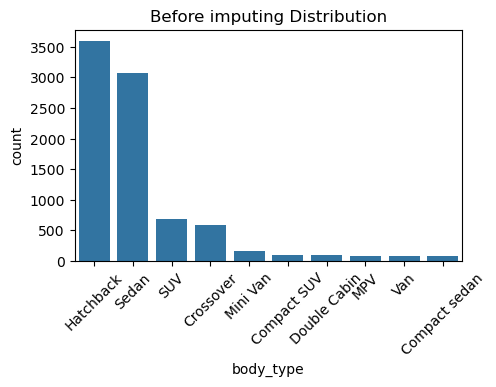

In [418]:
plt.figure(figsize=(5, 3))
plt.subplot(1, 1, 1)

top_10 = df['body_type'].value_counts().nlargest(10).index.tolist()
sns.countplot(data=df, x='body_type', order=top_10)
plt.title('Before imputing Distribution')
plt.xticks(rotation=45)
plt.show()

In [419]:
df['body_type'].fillna(df['body_type'].mode()[0],inplace=True)

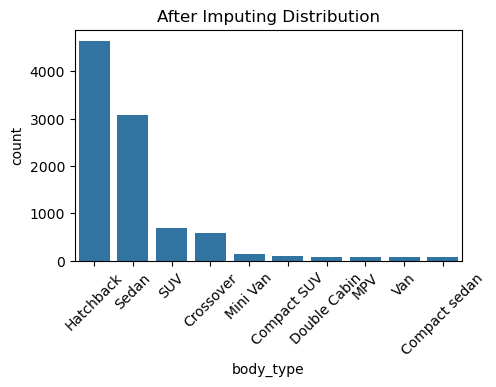

In [420]:
plt.figure(figsize=(5, 3))
plt.subplot(1, 1, 1)

top_10 = df['body_type'].value_counts().nlargest(10).index.tolist()
sns.countplot(data=df, x='body_type', order=top_10)
plt.title('After Imputing Distribution')
plt.xticks(rotation=45)
plt.show()

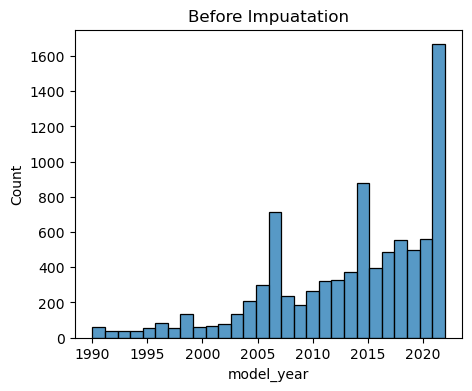

In [421]:
plt.figure(figsize=(5, 4))
plt.subplot(1, 1, 1)
sns.histplot(data=df, x='model_year')
plt.title('Before Impuatation')
plt.show()

In [422]:
df[df['model_year'].isna()]['model_name'].value_counts().head()

model_name
Suzuki Alto VXR 2024        45
Suzuki Alto VXR 2023        31
Haval H6 HEV 2024           28
Suzuki Alto VXL AGS 2023    21
Suzuki Alto VXL AGS 2024    20
Name: count, dtype: int64

In [423]:
import re

def extract_year_from_name(name):
    match = re.search(r'(19|20)\d{2}', str(name))
    if match:
        return int(match.group())
    return None

df.loc[df['model_year'].isna(), 'model_year'] = df[df['model_year'].isna()]['model_name'].apply(extract_year_from_name)

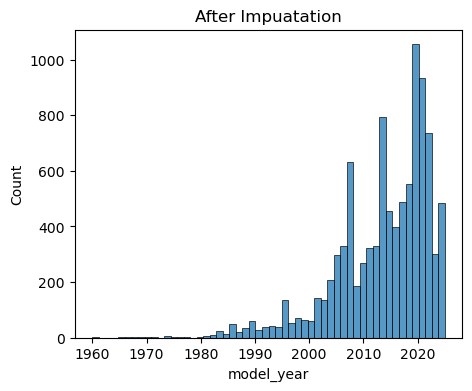

In [424]:
plt.figure(figsize=(5, 4))
plt.subplot(1, 1, 1)
sns.histplot(data=df, x='model_year')
plt.title('After Impuatation')
plt.show()

In [427]:
df.dropna(inplace=True)

In [429]:
(df.isnull().sum() / len(df)* 100).sort_values(ascending = False)

brand              0.0
model_name         0.0
province           0.0
location           0.0
model_year         0.0
fuel_type          0.0
transmission       0.0
km_driven          0.0
registered_in      0.0
color              0.0
assembly           0.0
engine_capacity    0.0
engine_power       0.0
body_type          0.0
last_updated       0.0
price              0.0
dtype: float64

From title remove the model yr bcz we already have year of model in dataset

In [431]:
df['model_name'] = df['model_name'].str.replace(r'\b\d{4}$', '', regex=True).str.strip()

-------------